# Pairs Trading

## Introductions
This report aims to construct a trading strategy that based on a pair or a basket of assets that their movements closely tracking with each other. This empirical phenomena is known as **cointegration** that is prevalent not only in the field of quantitative finance, but on the majority of quantitative disciplines as well. Traditionally, the cointegrated assets are related through the underlying economics drivers (commodity prices, rates, etc.).

Here, the strategy relying on cointegration of assets is attempted on the large cap Thai stocks which there exists a rather well-known example of the stocks with cointegrated behaviour: PTT, PTTEP, and PTTGC. The PTT Public Company Limited is the most prominent petroleum company with market cap consistendly staying amongst top five in the Stock Exchange of Thailand (SET Exchange), while PTTEP is the exploration and production arm of within the same conlgomorate. PTTGC also exhibits cointegrated behavior with PTT, PTTEP. For years, the stocks have been the prime example of cointegration in the Thai stock market. One of the objectives is to take the price evolutions of a pair of the stocks to clearly illustrate the mechanism and relevant procedure and statistics underpinning the strategy.

This materials is outlined as follows.
- We first outline the theoretical framework that is the foundation of pairs trading, as well as implementing the required computational routine to estimate the necessary statistics.
- Next, the Pairs trading strategy is applied on PTT and PTTEP. This section aims to examplify the Pairs trading strategy (and validating t
- After the strategy has been applie on a chosen set of equity pairs, the routine is packaged and reapplied on broader set of large cap stocks in Thai equity market to quantitative search for potentially better performing pairs compared to the baseline result. In doign so, we also hope to detect other trading opportunities on other sets of equities, instead of relying on the economic conventional knowledge regarding the core business of companies.
- Finally, the basket trading replying on multivariate cointegration is attempted.

## Cointegration, and Engle-Granger Procedure

In [3]:
from itertools import combinations
from typing import Union

import numpy as np
import pandas as pd
import datetime
import yfinance
import matplotlib.pyplot as plt
from scipy.stats import norm

from statsmodels.tools import add_constant

# To be deleted
from statsmodels.regression.linear_model import OLS as sm_OLS

In [4]:

def OLS_estimation(y: pd.DataFrame, z: pd.DataFrame) -> dict:
    _z = z.values.T
    _y = y.values.T
    _n_z = _z.shape[0]
    _n_y = _y.shape[0]
    _n = _y.shape[0]

    # Estimating coefficients
    _zz_trans_inv = np.linalg.inv(_z.dot(_z.T))
    _coefs = _y.dot(_z.T).dot(_zz_trans_inv)
    _df_coefs = pd.DataFrame(index=y.columns, columns=z.columns, dtype=float, data=_coefs)

    # Computing standard error of the coefficients
    _resid = _y - _coefs.dot(_z)
    _resid_cov = _resid.dot(_resid.T) / (_resid.shape[1] - _n_z)
    _coefs_se = np.sqrt(np.kron(_zz_trans_inv, _resid_cov).diagonal()).reshape(_n_z, _n_y).T
    _df_coefs_se = pd.DataFrame(index=y.columns, columns=z.columns, dtype=float, data=_coefs_se)

    # t-Stats
    _t_stats = _df_coefs / _coefs_se

    # p-values
    _p_values = pd.DataFrame(index=_t_stats.index, columns=_t_stats.columns, data=2 * norm.sf(np.abs(_t_stats)), dtype=float)

    # Saving other information
    aic = np.linalg.det(_resid_cov) + 2 * (_n_z * _n_y) / _n
    bic = np.linalg.det(_resid_cov) + np.log(_n) * (_n_z * _n_y) / _n
    return {'results': pd.concat([_df_coefs, _df_coefs_se, _t_stats, _p_values], keys=['coefficient', 'std. error', 't-stats', 'p-values'], axis=1).stack(),
            'resid': _resid,
            'aic': aic,
            'bic': bic}

def produce_lags(z: Union[pd.DataFrame, pd.Series], lags: int = 1) -> pd.DataFrame:
    if isinstance(z, pd.Series):
        z = z.to_frame()
    _z = pd.DataFrame(index=z.index, columns=pd.MultiIndex.from_product([range(1, lags+1), z.columns]), dtype=float)
    for l in range(1, lags+1):
        _z.loc[:, (l, slice(None))] = z.shift(l).values
    return _z

def adf(residual, lags: int = 1):
    pass

In [5]:
from sklearn.model_selection import train_test_split
df_set50_stats = pd.read_excel(r"SET50_stats.xlsx", header=1, index_col=0)
universe_raw = df_set50_stats.sort_values('MCap (M)', ascending=False).index.astype(str)
universe = list(map(str.upper, universe_raw))  # SCB has a special name change
universe.remove("SCB")

df_all_prices = yfinance.download([f'{s}.BK' for s in universe],
                                  start=datetime.date(2010, 1, 1),
                                  end=datetime.date(2022, 1, 1))
df_prices: pd.DataFrame = (df_all_prices
                           .dropna(how='all')
                           .dropna(how='any', thresh=int(0.80 * len(df_all_prices)), axis=1)
                           .dropna(how='any', axis=0))['Adj Close']
df_prices = df_prices.loc[:, (df_prices.iloc[-1, :] / df_prices.iloc[0, :]) < 10.0]
df_prices, df_prices_test = train_test_split(df_prices, test_size=0.5, train_size=0.5, shuffle=False)
df_returns = df_prices.pct_change()

print(f'Number of the stock in the final universe = {len(df_prices.columns)}')
df_prices

[*********************100%***********************]  49 of 49 completed
Number of the stock in the final universe = 31


,ADVANC.BK,BANPU.BK,BBL.BK,BDMS.BK,BEM.BK,BH.BK,BLA.BK,BTS.BK,CPALL.BK,CPF.BK,...,MINT.BK,PTT.BK,PTTEP.BK,PTTGC.BK,SCC.BK,TISCO.BK,TOP.BK,TRUE.BK,TTB.BK,TU.BK
Date,,,,,,,,,,,,,,,,,,,,,
2011-10-21,73.147255,27.857267,96.767807,5.454079,1.038602,31.174370,25.094757,2.063673,18.364090,20.733147,...,7.160355,18.743090,94.428261,33.765812,194.847168,15.029223,34.246025,2.222732,0.879459,8.555654
2011-10-25,76.804626,28.527374,100.944839,5.454079,1.038602,31.376797,24.657061,2.063673,18.464993,21.269344,...,7.197455,19.601051,96.896942,38.768166,206.308746,15.635242,35.575966,2.238608,0.886330,8.719398
2011-10-26,76.499847,28.623100,99.900604,5.475137,1.038602,31.376797,24.073462,2.063673,18.162291,21.269344,...,7.234557,19.337057,96.588394,38.611843,210.354065,15.514038,35.908459,2.190978,0.872588,8.801270
2011-10-27,76.804626,29.388935,101.641014,5.706780,1.059375,31.376797,25.240652,2.099878,18.263191,21.448078,...,7.382957,20.195021,96.588394,40.175072,211.702454,16.362463,37.404636,2.286238,0.920683,8.801270
2011-10-28,76.195061,29.963318,103.381424,5.622545,1.059375,32.186527,24.657061,2.136083,18.666794,21.448078,...,7.420058,20.591003,100.600044,41.581985,212.376617,16.604870,38.900822,2.222732,0.927554,8.842205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-11-14,116.473930,15.440614,129.206741,19.939396,6.780265,163.286957,45.365345,6.739108,53.808765,24.077084,...,33.149052,25.984619,59.353035,45.442974,384.248627,35.095928,57.745644,6.430132,1.540215,17.750162
2016-11-15,116.872818,14.891967,128.793930,19.759764,6.917704,163.728256,45.583450,6.739108,53.586418,23.869524,...,33.149052,26.779251,61.243252,46.219780,381.086121,35.095928,58.149467,6.475736,1.540215,17.424473
2016-11-16,114.878410,14.735208,127.968323,19.759764,6.871891,162.845627,45.365345,6.739108,54.253468,23.869524,...,33.149052,26.779251,61.432274,46.996582,377.923553,35.259930,57.139931,6.703755,1.525115,17.343048


Text(0, 0.5, 'Stock Price (Normalized)')

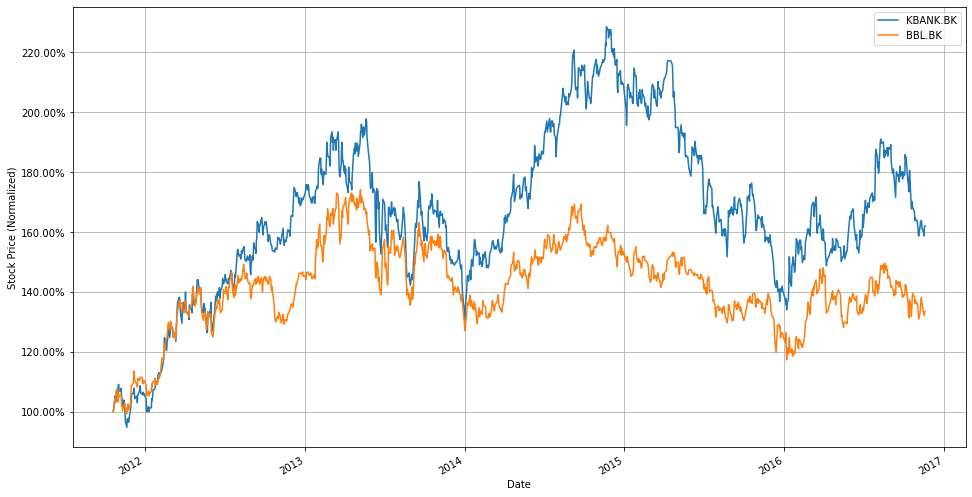

In [6]:
ax_ptt_prices: plt.Axes = df_prices.divide(df_prices.iloc[0, :])[['KBANK.BK', 'BBL.BK']].plot()
fig_ptt_prices: plt.Figure = ax_ptt_prices.get_figure()
fig_ptt_prices.set_size_inches(16, 9)
ax_ptt_prices.grid()
ax_ptt_prices.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda _y, _: f'{_y * 100:.2f}%'))
ax_ptt_prices.set_ylabel("Stock Price (Normalized)")

In [7]:
var_lags = 3
var_y = df_returns[var_lags:]
var_z = produce_lags(df_prices, var_lags)
var_z = add_constant(var_z.dropna(how='any'))
var_y = var_y.loc[var_z.index]
pd.concat([var_y, var_z], axis=1)

C:\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,ADVANC.BK,BANPU.BK,BBL.BK,BDMS.BK,BEM.BK,BH.BK,BLA.BK,BTS.BK,CPALL.BK,CPF.BK,...,"(3, MINT.BK)","(3, PTT.BK)","(3, PTTEP.BK)","(3, PTTGC.BK)","(3, SCC.BK)","(3, TISCO.BK)","(3, TOP.BK)","(3, TRUE.BK)","(3, TTB.BK)","(3, TU.BK)"
Date,,,,,,,,,,,,,,,,,,,,,
2011-10-27,0.003984,0.026756,0.017421,0.042308,0.020000,0.000000,0.048485,0.017544,0.005556,0.008403,...,7.160355,18.743090,94.428261,33.765812,194.847168,15.029223,34.246025,2.222732,0.879459,8.555654
2011-10-28,-0.007937,0.019544,0.017123,-0.014760,0.000000,0.025807,-0.023121,0.017241,0.022099,0.000000,...,7.197455,19.601051,96.896942,38.768166,206.308746,15.635242,35.575966,2.238608,0.886330,8.719398
2011-10-31,0.044000,0.003195,0.006734,0.011236,0.000000,0.000000,0.017751,0.000000,0.016216,0.008333,...,7.234557,19.337057,96.588394,38.611843,210.354065,15.514038,35.908459,2.190978,0.872588,8.801270
2011-11-01,0.003831,-0.041401,-0.040133,-0.003704,-0.019608,0.000000,0.000000,0.000000,-0.015957,-0.008265,...,7.382957,20.195021,96.588394,40.175072,211.702454,16.362463,37.404636,2.286238,0.920683,8.801270
2011-11-02,0.003816,0.000000,0.017421,0.000000,0.000000,0.012579,0.023256,0.033898,-0.010811,0.016667,...,7.420058,20.591003,100.600044,41.581985,212.376617,16.604870,38.900822,2.222732,0.927554,8.842205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-11-14,-0.020134,-0.039025,-0.021875,-0.026316,-0.032680,-0.026316,-0.009524,-0.005882,-0.016260,-0.056911,...,35.753620,27.414965,61.432274,46.025581,393.736267,35.751930,57.947556,6.931773,1.570416,17.913008
2016-11-15,0.003425,-0.035533,-0.003195,-0.009009,0.020270,0.002703,0.004808,0.000000,-0.004132,-0.008621,...,35.280060,27.097105,61.621292,45.831375,398.480072,35.751930,60.572357,6.931773,1.570416,17.750162
2016-11-16,-0.017065,-0.010526,-0.006410,0.000000,-0.006623,-0.005391,-0.004785,0.000000,0.012448,0.000000,...,34.569725,26.620325,61.054222,45.637177,392.155029,35.751930,59.562828,6.612547,1.555315,17.750162


,ADVANC.BK,BANPU.BK,BBL.BK,BDMS.BK,BEM.BK,BH.BK,BLA.BK,BTS.BK,CPALL.BK,CPF.BK,...,MINT.BK,PTT.BK,PTTEP.BK,PTTGC.BK,SCC.BK,TISCO.BK,TOP.BK,TRUE.BK,TTB.BK,TU.BK
ADVANC.BK,1.000000,0.200478,0.358983,0.258875,0.122934,0.206816,0.209845,0.218553,0.217715,0.231187,...,0.231205,0.302689,0.215905,0.244043,0.259988,0.225022,0.179455,0.379339,0.263622,0.095592
BANPU.BK,0.200478,1.000000,0.300644,0.199397,0.164321,0.198557,0.193663,0.220267,0.190203,0.234752,...,0.216267,0.408768,0.375902,0.360349,0.327432,0.208110,0.331570,0.259802,0.252005,0.125863
BBL.BK,0.358983,0.300644,1.000000,0.285435,0.177356,0.223208,0.259977,0.285552,0.301369,0.330551,...,0.318655,0.387925,0.331036,0.370232,0.393665,0.359225,0.338026,0.298338,0.367112,0.218154
BDMS.BK,0.258875,0.199397,0.285435,1.000000,0.177030,0.330371,0.228395,0.245969,0.247762,0.234113,...,0.331609,0.224363,0.223055,0.241137,0.282422,0.251245,0.216281,0.318970,0.234996,0.170303
BEM.BK,0.122934,0.164321,0.177356,0.177030,1.000000,0.138512,0.132860,0.233420,0.170396,0.143917,...,0.149584,0.174888,0.169320,0.190533,0.191147,0.143014,0.150709,0.269677,0.238874,0.084842
BH.BK,0.206816,0.198557,0.223208,0.330371,0.138512,1.000000,0.175056,0.213433,0.272608,0.175379,...,0.231555,0.203121,0.201793,0.218812,0.219573,0.191975,0.162112,0.208438,0.211691,0.178986
BLA.BK,0.209845,0.193663,0.259977,0.228395,0.132860,0.175056,1.000000,0.230365,0.244237,0.233875,...,0.221583,0.212944,0.165427,0.239397,0.261007,0.232721,0.232227,0.236573,0.180813,0.084707
BTS.BK,0.218553,0.220267,0.285552,0.245969,0.233420,0.213433,0.230365,1.000000,0.229774,0.253127,...,0.253339,0.269646,0.212011,0.271078,0.284228,0.239912,0.232782,0.356798,0.323509,0.140515
CPALL.BK,0.217715,0.190203,0.301369,0.247762,0.170396,0.272608,0.244237,0.229774,1.000000,0.368679,...,0.247466,0.246041,0.261528,0.271969,0.255645,0.226204,0.233768,0.254309,0.251961,0.208427
CPF.BK,0.231187,0.234752,0.330551,0.234113,0.143917,0.175379,0.233875,0.253127,0.368679,1.000000,...,0.220595,0.306208,0.265318,0.317169,0.286731,0.227917,0.235229,0.308044,0.214819,0.261213


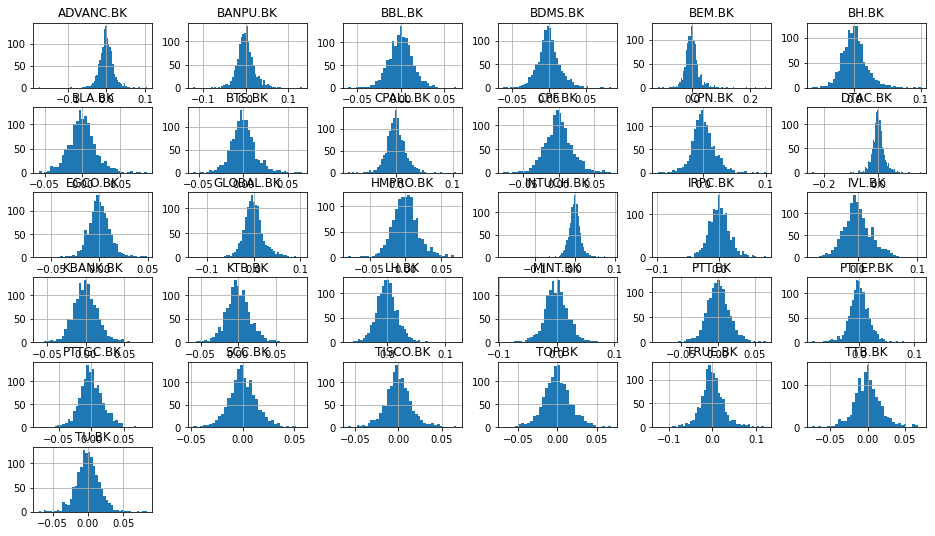

In [19]:
dict_var_results = OLS_estimation(var_y, var_z)
df_var_results = dict_var_results['results']
predicted_return = df_var_results['coefficient'].unstack().dot(var_z.T).T
df_residuals = var_y - predicted_return
error_hist_plots = df_residuals.hist(bins='auto')
fig_hist_plots: plt.Figure = error_hist_plots[0, 0].get_figure()
fig_hist_plots.set_size_inches(16, 9)
df_residuals.corr()

In [36]:
# Euler-Granger
p_a_stock = 'INTUCH.BK'
p_b_stock = 'ADVANC.BK'
p_a: pd.Series = df_prices[p_a_stock]
p_b: pd.Series = df_prices[p_b_stock]
df_p_a: pd.DataFrame = p_a.to_frame()
df_p_b: pd.DataFrame = p_b.to_frame()
pd.concat([df_p_a, add_constant(df_p_b)], axis=1)

C:\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,INTUCH.BK,const,ADVANC.BK
Date,,,
2011-10-21,18.464603,1.0,73.147255
2011-10-25,18.736145,1.0,76.804626
2011-10-26,18.328835,1.0,76.499847
2011-10-27,18.328835,1.0,76.804626
2011-10-28,18.328835,1.0,76.195061
...,...,...,...
2016-11-14,39.909222,1.0,116.473930
2016-11-15,39.909222,1.0,116.872818
2016-11-16,39.519855,1.0,114.878410


C:\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


coefficient  std. error     t-stats  p-values
INTUCH.BK const        -0.359453    0.323184   -1.112227  0.266041
          ADVANC.BK     0.314864    0.002205  142.777576  0.000000

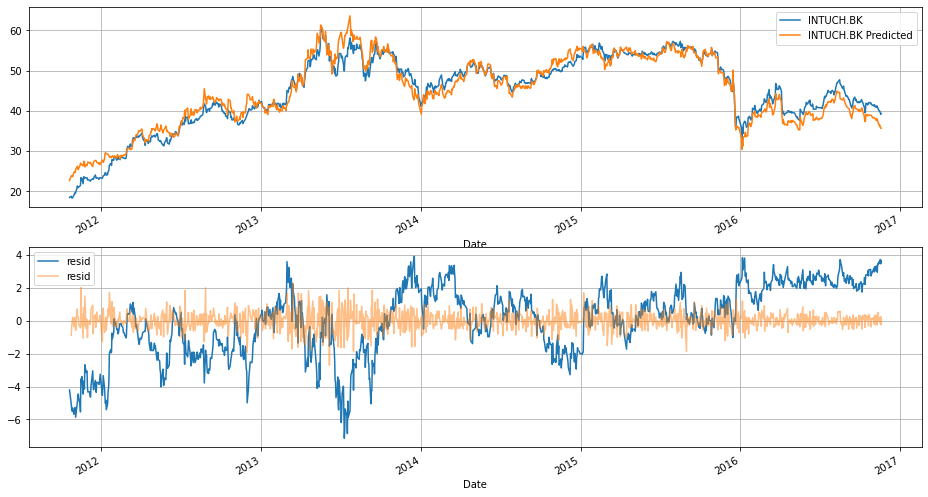

In [45]:
dict_pairs_results = OLS_estimation(df_p_a, add_constant(df_p_b))
df_pair_ols = dict_pairs_results['results']
p_a_predicted = add_constant(df_p_b).dot(df_pair_ols['coefficient'].values)
pair_resid = (p_a - p_a_predicted).rename('resid')

fig_pair: plt.Figure = plt.figure(figsize=(16, 9))
ax_p_a, ax_p_a_resid = fig_pair.subplots(2, 1)
p_a.plot(ax=ax_p_a, label=p_a_stock)
p_a_predicted.plot(ax=ax_p_a, label=f'{p_a_stock} Predicted')
pair_resid.plot(ax=ax_p_a_resid)
pair_resid.diff().plot(ax=ax_p_a_resid, alpha=0.5)
for ax in [ax_p_a, ax_p_a_resid]:
    ax.grid()
    ax.legend()

df_pair_ols

In [39]:
adf_lags = 1
pair_resid_diff = pair_resid.diff().rename('delta_resid')
adf_y: pd.DataFrame = pair_resid_diff.to_frame()
df_adf_resid_lags = produce_lags(pair_resid, 1)  # Always lag 1
df_adf_delta_resid_lags = produce_lags(pair_resid_diff, adf_lags)
adf_z = pd.concat([df_adf_resid_lags, df_adf_delta_resid_lags], axis=1)
_adf_notna_idx = pd.concat([adf_y, adf_z], axis=1).notna().all(axis=1)
dict_adf_results = OLS_estimation(adf_y.loc[_adf_notna_idx], adf_z.loc[_adf_notna_idx])
dict_adf_results['results']

coefficient      p-values std. error   t-stats
                                  1             1          1         1
delta_resid delta_resid   -0.191864  5.421770e-12    0.02783 -6.894072
            resid         -0.029742  5.840413e-05    0.00740 -4.019168

In [48]:
from CVTables_Johansen import tableADF
sr_adf_crits = pd.Series(index=[0.01, 0.05, 0.1, 0.9, 0.95, 0.99], data=tableADF(len(adf_y), 1), dtype=float)
sr_adf_crits

0.01   -3.997830
0.05   -3.431820
0.10   -3.161710
0.90   -1.260320
0.95   -0.956327
0.99   -0.305719
dtype: float64

In [49]:
# ECM
ecm_p_a_y = df_p_a.diff()
ecm_p_a_z = pd.concat([p_b.diff(), pair_resid], axis=1)
ecm_p_b_y = df_p_b.diff()
ecm_p_b_z = pd.concat([p_a.diff(), pair_resid], axis=1)
ecm_nonna_idx = pd.concat([ecm_p_b_y, ecm_p_b_z], axis=1).dropna().index
dict_ecm_results_p_a = OLS_estimation(ecm_p_a_y.loc[ecm_nonna_idx], ecm_p_a_z.loc[ecm_nonna_idx])
dict_ecm_results_p_b = OLS_estimation(ecm_p_b_y.loc[ecm_nonna_idx], ecm_p_b_z.loc[ecm_nonna_idx])
pd.concat([dict_ecm_results_p_a['results'], dict_ecm_results_p_b['results']])

coefficient  std. error    t-stats      p-values
INTUCH.BK ADVANC.BK     0.216717    0.004907  44.163323  0.000000e+00
          resid         0.016506    0.006566   2.513819  1.194318e-02
ADVANC.BK INTUCH.BK     2.820883    0.063874  44.163323  0.000000e+00
          resid        -0.119285    0.023507  -5.074443  3.886331e-07

In [66]:
df_ou_y = pair_resid.rename('resid').to_frame()[1:]
# df_ou_z = pair_resid.shift(1).rename('resid_lag1').dropna().to_frame()
df_ou_z = produce_lags(pair_resid, 1).dropna()
dict_ou_results = OLS_estimation(df_ou_y, add_constant(df_ou_z))
df_ou_estimation: pd.DataFrame = dict_ou_results['results']

C:\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [68]:
tau = 1.0 / 252.0
cee = df_ou_estimation.iloc[0, 0]
bee = df_ou_estimation.iloc[1, 0]

Reversion mean = 0.1743, Reversion Speed = 9.1451


<AxesSubplot:xlabel='Date'>

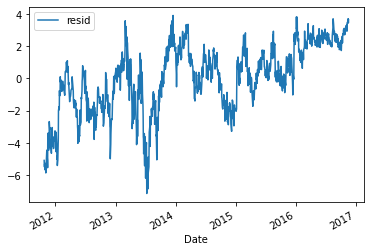

In [69]:
reversion_mean = cee / (1.0 - bee)
reversion_speed = -1 * np.log(bee) / tau
print(f"Reversion mean = {reversion_mean:.4f}, Reversion Speed = {reversion_speed:.4f}")
df_ou_y.plot()

In [72]:
df_ou_y_predicted = add_constant(df_ou_z).dot(df_ou_estimation['coefficient'].values)
ou_resid = df_ou_y.squeeze() - df_ou_y_predicted
vol_eq = np.sqrt(ou_resid.dot(ou_resid.T) * tau / (1 - np.exp(-2 * reversion_speed * tau)))
print(f"Reversion Deviation = {vol_eq}")

Reversion Deviation = 4.673387466709461


C:\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


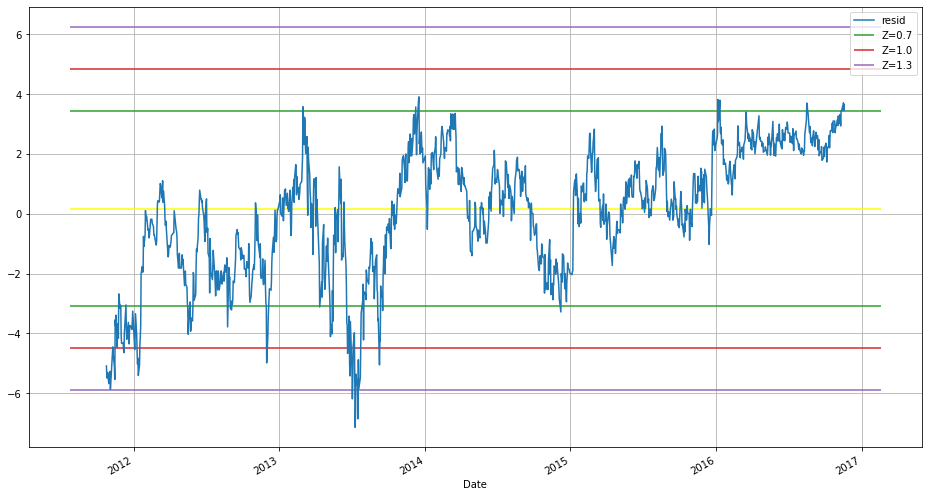

In [77]:
z_levels = [0.7, 1.0, 1.3]
fig_vary_z: plt.Figure = plt.figure(figsize=(16, 9))
ax_vary_z: plt.Axes = fig_vary_z.add_subplot()
df_ou_y.plot(ax=ax_vary_z)
x_minmax = ax_vary_z.get_xlim()
ax_vary_z.hlines(reversion_mean, *x_minmax, color='yellow')
for i, z_value in enumerate(z_levels):
    lower_band = reversion_mean - z_value * vol_eq
    upper_band = reversion_mean + z_value * vol_eq
    ax_vary_z.hlines(lower_band, *x_minmax, color=f'C{i+2}')
    ax_vary_z.hlines(upper_band, *x_minmax, color=f'C{i+2}', label=f'Z={z_value}')
ax_vary_z.grid()
ax_vary_z.legend()

0.3148643258515662

In [58]:
from statsmodels.tsa.vector_ar.var_model import VAR
var = VAR(df_returns.dropna()).fit(lags)
var.summary()
# cov = np.kron(_zz_trans_inv, _resid.dot(_resid.T) / (_resid.shape[1] - _z.shape[0]))
# np.array([var.cov_params().sum(axis=1), cov.sum(axis=1)]).T

/Users/poopah/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


NameError: name 'lags' is not defined

In [15]:
from statsmodels.tsa.stattools import adfuller


def adf_test(timeseries):
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    return dfoutput

adf_test(ols.resid)

Test Statistic                   -2.721899
p-value                           0.070325
#Lags Used                        0.000000
Number of Observations Used    1242.000000
Critical Value (1%)              -3.435626
Critical Value (5%)              -2.863870
Critical Value (10%)             -2.568010
dtype: float64

In [24]:
sr_period_return = df_prices.iloc[-1] / df_prices.iloc[0]
df_prices = df_prices.T[sr_period_return < 10.0].T

In [25]:
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):
    dftest = adfuller(timeseries)
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    return dfoutput

def euler_granger(p_a: pd.Series,
                  p_b: pd.Series):
    ols_result = OLS(endog=p_a, exog=add_constant(p_b)).fit()
    return adf_test(ols_result.resid)

df_results = pd.DataFrame(index=pd.MultiIndex.from_tuples(list(combinations(df_prices.columns, 2))),
                          columns=euler_granger(df_prices.iloc[:, 0], df_prices.iloc[:, 0]).index,
                          dtype=float)

In [27]:
for s_1, s_2 in combinations(df_prices.columns, 2):
    result = euler_granger(df_prices[s_1], df_prices[s_2])
    print(f"{s_1:<9}, {s_2:<9}: {result['p-value']:.6f}")
    df_results.loc[(s_1, s_2)] = result

TypeError: unsupported format string passed to tuple.__format__

In [ ]:
df_results = df_results.sort_values('p-value', ascending=False)
df_results

In [ ]:
fig_top_stats: plt.Figure = plt.figure(figsize=(20, 20))
list_axes: list[plt.Axes] = fig_top_stats.subplots(3, 3).ravel()

for i, ax_i in enumerate(list_axes):
    s_1, s_2 = df_results.index[i]
    p_value = df_results.loc[(s_1, s_2), 'p-value']
    maxlag = df_results.loc[(s_1, s_2), '#Lags Used']
    df_pair_price = df_prices[[s_1, s_2]]
    df_pair_price /= df_prices.iloc[0]
    df_pair_price.plot(ax=ax_i)
    resid = OLS(endog=df_pair_price[s_1], exog=add_constant(df_pair_price[s_2])).fit().resid
    ax_2 = ax_i.twinx()
    resid.plot(ax=ax_2, color='green', linestyle='--')

In [ ]:
from statsmodels.tsa.vector_ar import vecm

df_set50_stats_mcap = df_set50_stats.sort_values('MCap (M)', ascending=False)
top_12_mcap = df_set50_stats_mcap.loc[[s for s in df_set50_stats_mcap.index if f'{s}.BK' in df_prices.columns]].head(12).index.to_list()
johassen = vecm.coint_johansen(df_prices[[f'{s}.BK' for s in top_12_mcap]], 0, 2)
johassen.trace_stat_crit_vals